
# 用字符级RNN分类名称

**作者**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

我们将建立和训练一个基本的字符级RNN进行分类单词. 字符级别的RNN将单词读为一系列字符 - 在每个步骤输出一个预测和“隐藏状态”,
将先前的隐藏状态作为下一步的输入. 我们采取最后的预测作为输出,即该单词属于哪一类.

具体来说,我们将用18种语言的几千个姓氏作为训练集并根据拼写预测名称来自哪种语言，哪个国籍

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**推荐阅读:**

假设你至少已经安装了PyTorch,知道Python和了解张量:

-  http://pytorch.org/ 安装步骤
-  :doc:`/beginner/deep_learning_60min_blitz` 大体了解PyTorch
-  :doc:`/beginner/pytorch_with_examples` 深入概括
-  :doc:`/beginner/former_torchies_tutorial` 假设你是前Lua Torch用户

了解RNN及其工作方式也很有用:

-  `递归神经网络的不合理有效性 <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   展示了一堆真实生活的例子
-  `理解LSTM网络 <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   是关于LSTM的具体内容,但也包含有关RNN的一般信息

## 准备数据


.. 注意::
   从这里下载数据
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   并将其解压到当前目录.

在 ``data/names`` 目录中包含18个名为as的文本文件 "[Language].txt" .
每个文件都包含一堆名称,每个名称一行大多是罗马化（但我们仍然需要从Unicode转换为ASCII）.

我们最终会得到每种语言的名称列表字典 ``{language: [names ...]}``  通用变量“类别”和“行”
（在我们的例子中用于语言和名称）用于以后的扩展性。

In [1]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 将 Unicode 字符串转换为纯 ASCII 编码, 这里感谢 http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 构建category_lines字典, 每种语言的名称列表
category_lines = {}
all_categories = []

# 读取一个文件并分成几行
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
n_categories

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


18

现在我们有 ``category_lines``, 这是一个映射每个类别的字典
(语言) 到行列表 (名称). 我们也跟踪
``all_categories`` (只是一个语言列表) 和 ``n_categories`` 为以后做参考.




In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


将名字转化为张量
--------------------------

现在我们已经组织了所有的名字,我们需要将它们变成张量以便使用它们.

为了表示单个字母,我们使用大小为 ``<1 x n_letters>`` 的"单热矢量".
除了当前字母的索引处的1以外,单热矢量剩余填充0, e.g. ``"b" = <0 1 0 0 0 ...>``.

为了说出一个词,我们将其中的一部分加入到二维矩阵中
``<line_length x 1 x n_letters>``.

额外的1维度是因为PyTorch假定所有内容都是批量的 - 我们在这里只使用1的批量大小.




In [3]:
import torch

# 从all_letters中查找字母索引, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 只是为了演示, 把一个字母变成一个 <1 x n_letters> 张量
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 把一行变成一个 <line_length x 1 x n_letters>,
# 或一批单热字符向量
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


创建网络
====================

在autograd之前, 在Torch中创建一个循环神经网络涉及到克隆几个步骤一个图层的参数.
图层保持隐藏状态和渐变, 现在完全由图形本身处理.
这意味着您可以以非常“纯粹”的方式实现RNN, 作为常规的前馈层.

这个RNN模块 (大部分都是复制 `the PyTorch for Torch users tutorial <http://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net>`__)
只有2个线性层可以在输入和隐藏状态下运行, 在输出之后有一个LogSoftmax层.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [4]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

为了运行这个网络的一个步骤, 我们需要传递一个输入 (在我们的例子中是当前字母的张量) 和一个先前的隐藏状态 (我们首先初始化为零) .
我们将返回输出 (每种语言的概率) 和下一个隐藏状态 (我们为下一步保留).
请记住, PyTorch模块对变量进行操作, 而不是直接对张量进行操作.




In [5]:
input = Variable(letterToTensor('A'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input, hidden)

为了提高效率我们不希望为每一步创建一个新的张量,
所以我们使用 ``lineToTensor`` 而不是 ``letterToTensor`` 并使用切片.
这可以通过预先计算批次的张量进一步优化.




In [6]:
input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9033, -2.8689, -2.9827, -2.8651, -2.8183, -2.8682, -3.0024, -2.8601,
         -2.9306, -2.8515, -2.9285, -2.8694, -2.8406, -2.8191, -2.9180, -2.8976,
         -3.0155, -2.8181]], grad_fn=<LogSoftmaxBackward>)


正如你所看到的输出是一个 ``<1 x n_categories>`` 张量,
每个项目都是该类别的可能性 (越高越有可能).




训练
========
准备训练
----------------------

在训练之前,我们应该做一些辅助功能.
首先是解释网络的输出, 我们知道这是每个类别的可能性.
我么可以使用 ``Tensor.topk`` 得到最大价值的指数:




In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', tensor(17))


我们也希望能够快速获得训练示例 (名称及其语言):




In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Koulaxizis
category = Italian / line = Romagnoli
category = English / line = Ewles
category = French / line = Marion
category = Spanish / line = Vega
category = Arabic / line = Wasem
category = Italian / line = Arrighi
category = French / line = Belanger
category = Irish / line = Conchobhar
category = Irish / line = Raghailligh


训练网络
--------------------

现在训练这个网络所需要的就是向大家展示一些例子, 让它猜测, 并告诉它是否是错误的.

对于损失函数 ``nn.NLLLoss`` 是适当的, 因为RNN的最后一层是 ``nn.LogSoftmax``.




In [9]:
criterion = nn.NLLLoss()

每个训练循环都会:

-  创建输入和目标张量
-  创建一个归零的初始隐藏状态
-  读入每个字母

   -  为下一个字母保持隐藏状态

-  比较最终输出与目标
-  反向传播
-  返回输出和损失




In [10]:
learning_rate = 0.005 # 如果设置得太高, 可能会爆炸. 如果太低, 可能无法学习.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 将参数梯度添加到它们的值,再乘以学习速率
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

现在我们只需要运行一些例子. 由于 ``train`` 函数返回输出和损失,我们可以打印它的猜测,并记录绘图的损失
既然有1000个例子, 我们只打印每个 ``print_every`` 的例子, 并取平均的损失.




In [11]:
import time
import math

n_iters = 75000
print_every = 5000
plot_every = 1000

# 跟踪绘图的损失
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # 打印循环数,损失,名称和猜测
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('iter: %d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 将当前损失平均值添加到损失清单
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

<ipython-input-10-c35096730220>:16: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1025.)
  p.data.add_(-learning_rate, p.grad.data)


iter: 5000 6% (0m 3s) 2.4320 Reier / German ✓
iter: 10000 13% (0m 7s) 2.5692 Walentowicz / German ✗ (Polish)
iter: 15000 20% (0m 11s) 0.8628 Mancini / Italian ✓
iter: 20000 26% (0m 17s) 2.2693 Ngai / Chinese ✗ (Korean)
iter: 25000 33% (0m 22s) 1.8069 Trukhin / Arabic ✗ (Russian)
iter: 30000 40% (0m 26s) 2.9036 Koning / Italian ✗ (Dutch)
iter: 35000 46% (0m 32s) 0.3137 Bobienski / Polish ✓
iter: 40000 53% (0m 37s) 0.0070 Warszawski / Polish ✓
iter: 45000 60% (0m 42s) 0.3850 Yuan / Chinese ✓
iter: 50000 66% (0m 47s) 1.9118 Koliha / Japanese ✗ (Czech)
iter: 55000 73% (0m 54s) 2.8273 Close / French ✗ (Greek)
iter: 60000 80% (0m 59s) 3.8372 Colon / Scottish ✗ (Spanish)
iter: 65000 86% (1m 3s) 1.6648 Monet / French ✓
iter: 70000 93% (1m 7s) 1.5752 Moshin / Irish ✗ (Russian)
iter: 75000 100% (1m 11s) 1.0207 Lagana / Italian ✓


绘制结果
--------------------

从 ``all_losses`` 绘制历史损失显示网络学习:




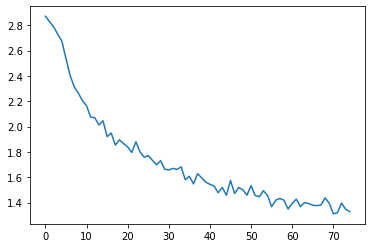

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

评估结果
======================

要查看网络在不同类别中的表现如何, 我们将创建一个混淆矩阵,
为每个实际语言 (行) 指示网络猜测哪种语言 (列).
为了计算混淆矩阵,一堆样本通过网络运行 ``evaluate()``,
这和 ``train()`` 减去反向传播是一样的.




<ipython-input-13-79c424747e07>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-13-79c424747e07>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


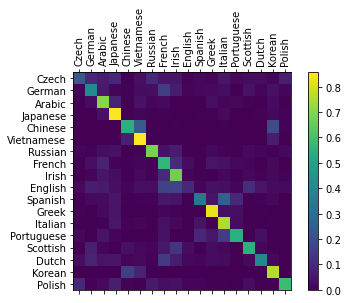

In [13]:
# 在混淆矩阵中跟踪正确的猜测
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 只要返回给定一行的输出即可
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 通过一堆示例并记录哪些是正确的猜测
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 通过将每一行除以其总和来标准化
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 设置绘图
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 设置轴
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

您可以从主轴上选取显示错误猜测哪些语言的亮点,
e.g. Chinese for Korean, and Spanish for Italian.
它似乎与希腊语很好,英语很差 (可能是因为与其他语言重叠).




在用户输入上运行
---------------------




In [14]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # 获取前N个类别
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Zhang')


> Dovesky
(-0.38) Russian
(-2.10) Czech
(-3.02) French

> Jackson
(-0.76) Scottish
(-1.63) Russian
(-2.04) English

> Satoshi
(-0.46) Japanese
(-1.89) Italian
(-2.24) Arabic

> Zhang
(-0.36) Chinese
(-1.53) Vietnamese
(-3.05) Korean


脚本的最终版本 `in the Practical PyTorch repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
将上面的代码分成几个文件:

-  ``data.py`` (加载文件)
-  ``model.py`` (定义RNN)
-  ``train.py`` (运行训练)
-  ``predict.py`` (用命令行参数运行 ``predict()`` )
-  ``server.py`` (使用bottle.py将预测用作JSON API)

运行 ``train.py`` 来训练和保存网络.

运行具有名称的 ``predict.py`` 来查看预测:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

运行 ``server.py`` 和查看 http://localhost:5533/Yourname 获取预测的JSON输出.




练习
=========

-  尝试使用不同的数据集 线条 -> 类别, 例如:

   -  任何单词 -> 语言
   -  姓 -> 性别
   -  角色名字 -> 作家
   -  页面标题 -> 博客或subreddit

-  通过更大和/或更好的形状网络获得更好的结果

   -  添加更多线性图层
   -  试试 ``nn.LSTM`` 和 ``nn.GRU`` 图层
   -  将多个这些RNN组合为更高级别的网络




本节完。